# Explore data & predict future trips using weather data.
This notebook has three main parts, firstly download weather data from climate Canada weather stations in Montréal (https://climate.weather.gc.ca) as well as BIXI data from (https://bixi.com). The various data files would then be prepared, cleaned and merged using Alteryx. Lastly, we will perform an exploratory analysis of the data through visualization create models for forecasting.

For more information and to view the visualiations please visit: https://github.com/Wolesword

## Import Data

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BIXI_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/3yrs_Bike_data.csv')

In [4]:
# Display the top rows of the data and describe to see large variations in data fields, also info on data types
# BIXI_raw.head()
# BIXI_raw.describe()
# BIXI_raw.info()

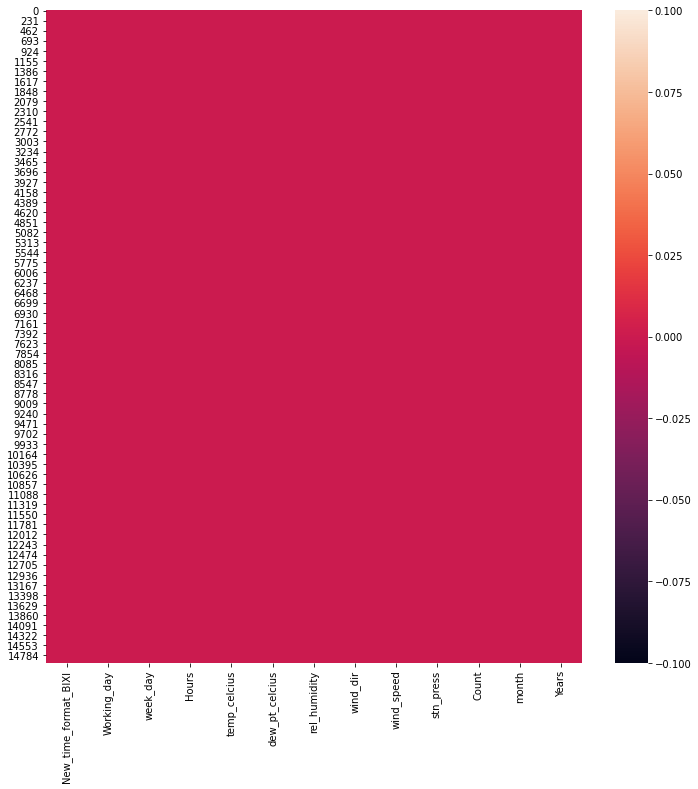

In [5]:
#  Check the veracity of the data. Identify the nulls in the data
plt.figure(figsize=(12,12))
sns.heatmap(BIXI_raw.isnull())

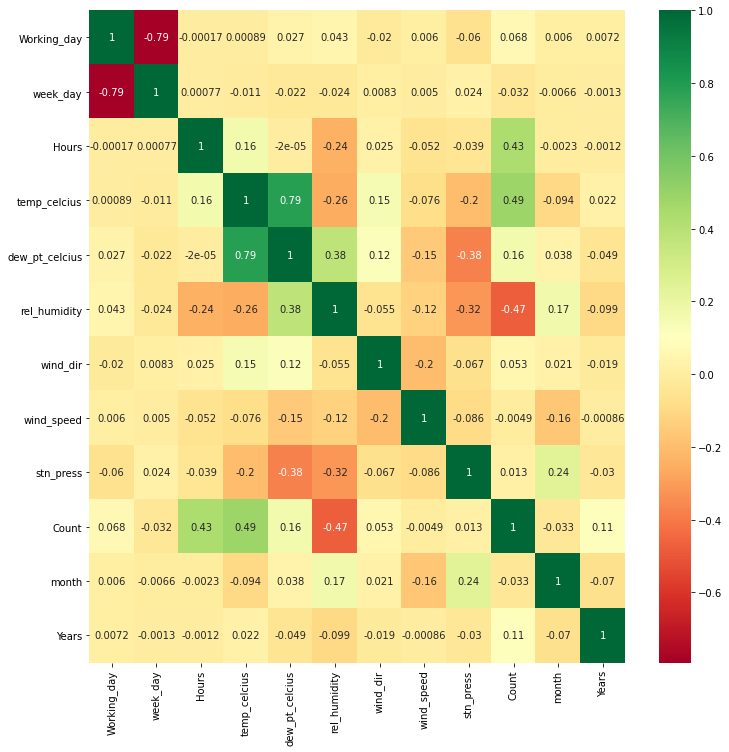

In [6]:
# Correlation matrix of the various fields using seaborn heatmap
cor_matrix = BIXI_raw.corr() # calculate the correlations
features_names = cor_matrix.index # Returns the names of the fields of the first occurence
plt.figure(figsize=(12,12)),
sns.heatmap(cor_matrix[features_names], annot=True, cmap="RdYlGn")

## Data Cleaning

In [7]:
BIXI_raw.head()

,New_time_format_BIXI,Working_day,week_day,Hours,temp_celcius,dew_pt_celcius,rel_humidity,wind_dir,wind_speed,stn_press,Count,month,Years
0,2017-04-15 00,0,6,0,11.4,-5.4,30,27,8,101.76,144,4,1
1,2017-04-15 01,0,6,1,10.8,-6.2,30,27,9,101.70,76,4,1
2,2017-04-15 02,0,6,2,10.9,-6.3,29,27,11,101.65,39,4,1
3,2017-04-15 03,0,6,3,10.2,-6.0,31,27,9,101.61,40,4,1
4,2017-04-15 04,0,6,4,8.4,-4.3,40,20,4,101.58,12,4,1


In [8]:
BIXI_raw.describe(include='all').loc['unique', :] # Includes all fields, and display the 'unique field only'
#BIXI_raw.describe(include='all')

New_time_format_BIXI    14954
Working_day               NaN
week_day                  NaN
Hours                     NaN
temp_celcius              NaN
dew_pt_celcius            NaN
rel_humidity              NaN
wind_dir                  NaN
wind_speed                NaN
stn_press                 NaN
Count                     NaN
month                     NaN
Years                     NaN
Name: unique, dtype: object

In [9]:
# BIXI_raw.Working_day.nunique() # Distinct observation, ignores NaN
# BIXI_raw.week_day.nunique() # 7 days a week
# BIXI_raw.Hours.nunique() # 24 hours in a day
# BIXI_raw.temp_celcius.nunique() # 426
# BIXI_raw.dew_pt_celcius.nunique() # 412
# BIXI_raw.rel_humidity.nunique()  # 87 unique relative humidity
# BIXI_raw.wind_dir.nunique() # 37 unique wind direction
# BIXI_raw.wind_speed.nunique() # 24 unique wind speed
# BIXI_raw.stn_press.nunique() # 470 Unique values

In [10]:
BIXI_raw = BIXI_raw.rename(columns={'New_time_format_BIXI':'start_date'})

In [11]:
BIXI_raw

,start_date,Working_day,week_day,Hours,temp_celcius,dew_pt_celcius,rel_humidity,wind_dir,wind_speed,stn_press,Count,month,Years
0,2017-04-15 00,0,6,0,11.4,-5.4,30,27,8,101.76,144,4,1
1,2017-04-15 01,0,6,1,10.8,-6.2,30,27,9,101.70,76,4,1
2,2017-04-15 02,0,6,2,10.9,-6.3,29,27,11,101.65,39,4,1
3,2017-04-15 03,0,6,3,10.2,-6.0,31,27,9,101.61,40,4,1
4,2017-04-15 04,0,6,4,8.4,-4.3,40,20,4,101.58,12,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14949,2019-10-31 19,1,4,19,12.3,11.9,97,1,12,98.66,166,10,3
14950,2019-10-31 20,1,4,20,10.3,9.8,97,1,13,98.60,133,10,3
14951,2019-10-31 21,1,4,21,9.2,8.7,97,3,15,98.60,119,10,3
14952,2019-10-31 22,1,4,22,8.5,7.9,96,2,11,98.47,121,10,3


In [12]:
BIXI_raw.start_date = pd.to_datetime(BIXI_raw.start_date) # Changed the format of start date to %Y-%m-%d
BIXI_raw.index = pd.DatetimeIndex(BIXI_raw.start_date) # Immutable ndarray of time
BIXI_raw = BIXI_raw.drop(labels=['start_date'], axis=1)
# BIXI_raw

## Grouping

In [13]:
BIXI_raw.head()

,Working_day,week_day,Hours,temp_celcius,dew_pt_celcius,rel_humidity,wind_dir,wind_speed,stn_press,Count,month,Years
start_date,,,,,,,,,,,,
2017-04-15 00:00:00,0,6,0,11.4,-5.4,30,27,8,101.76,144,4,1
2017-04-15 01:00:00,0,6,1,10.8,-6.2,30,27,9,101.70,76,4,1
2017-04-15 02:00:00,0,6,2,10.9,-6.3,29,27,11,101.65,39,4,1
2017-04-15 03:00:00,0,6,3,10.2,-6.0,31,27,9,101.61,40,4,1
2017-04-15 04:00:00,0,6,4,8.4,-4.3,40,20,4,101.58,12,4,1


In [14]:
BIXI_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14954 entries, 2017-04-15 00:00:00 to 2019-10-31 23:00:00
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Working_day     14954 non-null  int64  
 1   week_day        14954 non-null  int64  
 2   Hours           14954 non-null  int64  
 3   temp_celcius    14954 non-null  float64
 4   dew_pt_celcius  14954 non-null  float64
 5   rel_humidity    14954 non-null  int64  
 6   wind_dir        14954 non-null  int64  
 7   wind_speed      14954 non-null  int64  
 8   stn_press       14954 non-null  float64
 9   Count           14954 non-null  int64  
 10  month           14954 non-null  int64  
 11  Years           14954 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.5 MB


In [15]:
# Grouping data into hourly records using mean and modes

def grp(x):
    d = {}
    d['Working_day'] = x['Working_day'].agg(lambda x:x.value_counts().index[0])
    d['week_day'] = x['week_day'].agg(lambda x:x.value_counts().index[0])
    d['Hours'] = x['Hours'].agg(lambda x:x.value_counts().index[0])
    d['temp_celcius'] = x['temp_celcius'].min()
    d['dew_pt_celcius'] = x['dew_pt_celcius'].min()
    d['rel_humidity'] = x['rel_humidity'].mean()
    d['wind_dir'] = x['wind_dir'].agg(lambda x:x.value_counts().index[0])
    d['wind_speed'] = x['wind_speed'].agg(lambda x:x.value_counts().index[0])
    d['stn_press'] = x['stn_press'].agg(lambda x:x.value_counts().index[0])
    d['Count'] = x['Count'].sum()
    d['month'] = x['month'].agg(lambda x:x.value_counts().index[0])
    d['Years'] = x['Years'].agg(lambda x:x.value_counts().index[0])
    
    return pd.Series(d, index=['Working_day', 'week_day','Hours',  'temp_celcius',
    'dew_pt_celcius','rel_humidity', 'wind_dir', 'wind_speed', 'month', 'Years', 'stn_press','Count'])

In [16]:
# BIXI_New = BIXI_raw.groupby(['start_date']).apply(grp)

In [17]:
# BIXI_raw.reset_index(inplace=True)
# BIXI_raw['start_date'] = BIXI_raw['start_date'].dt.floor('D')
# BIXI_raw

In [18]:
BIXI_New = BIXI_raw
BIXI_New

,Working_day,week_day,Hours,temp_celcius,dew_pt_celcius,rel_humidity,wind_dir,wind_speed,stn_press,Count,month,Years
start_date,,,,,,,,,,,,
2017-04-15 00:00:00,0,6,0,11.4,-5.4,30,27,8,101.76,144,4,1
2017-04-15 01:00:00,0,6,1,10.8,-6.2,30,27,9,101.70,76,4,1
2017-04-15 02:00:00,0,6,2,10.9,-6.3,29,27,11,101.65,39,4,1
2017-04-15 03:00:00,0,6,3,10.2,-6.0,31,27,9,101.61,40,4,1
2017-04-15 04:00:00,0,6,4,8.4,-4.3,40,20,4,101.58,12,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-31 19:00:00,1,4,19,12.3,11.9,97,1,12,98.66,166,10,3
2019-10-31 20:00:00,1,4,20,10.3,9.8,97,1,13,98.60,133,10,3
2019-10-31 21:00:00,1,4,21,9.2,8.7,97,3,15,98.60,119,10,3


## Time series Analysis

In [19]:
BIXI_New.head()

,Working_day,week_day,Hours,temp_celcius,dew_pt_celcius,rel_humidity,wind_dir,wind_speed,stn_press,Count,month,Years
start_date,,,,,,,,,,,,
2017-04-15 00:00:00,0,6,0,11.4,-5.4,30,27,8,101.76,144,4,1
2017-04-15 01:00:00,0,6,1,10.8,-6.2,30,27,9,101.70,76,4,1
2017-04-15 02:00:00,0,6,2,10.9,-6.3,29,27,11,101.65,39,4,1
2017-04-15 03:00:00,0,6,3,10.2,-6.0,31,27,9,101.61,40,4,1
2017-04-15 04:00:00,0,6,4,8.4,-4.3,40,20,4,101.58,12,4,1


In [20]:
time = BIXI_New.index
output = BIXI_New.values[:, -3]
series = pd.Series(data=output, index=time)

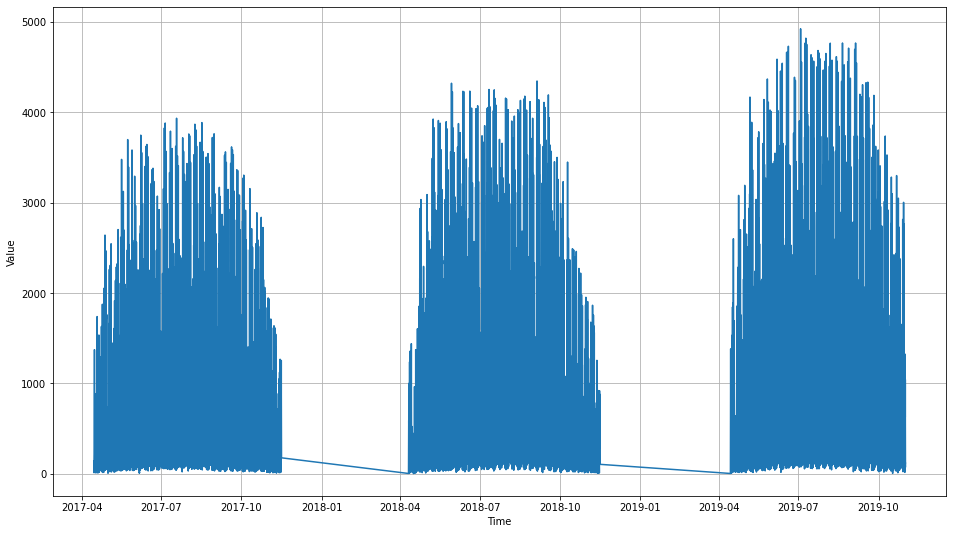

In [21]:
plt.figure(figsize=(16, 9))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [22]:
# sns.pairplot(BIXI_New)

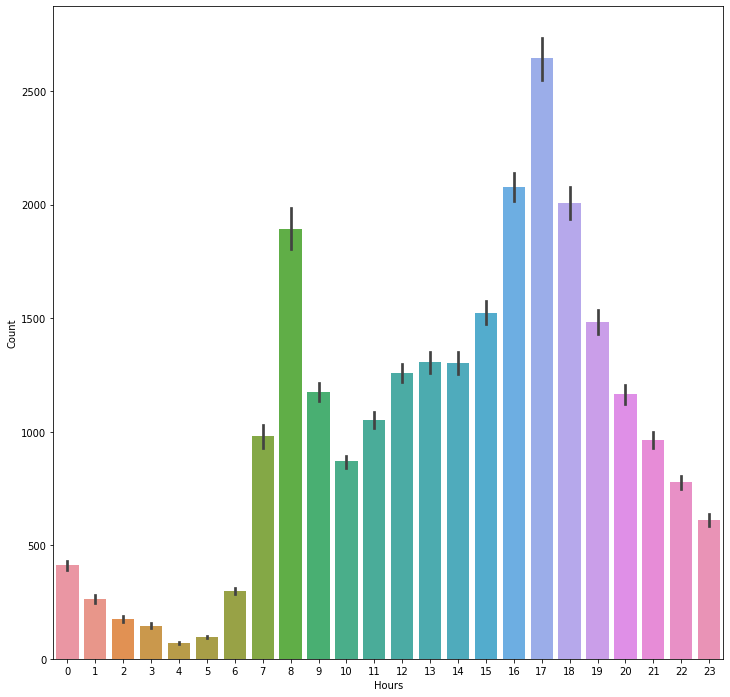

In [23]:
#Bike usage throughout the day
plt.figure(figsize=(12,12))
sns.barplot(x="Hours", y="Count", data=BIXI_New)

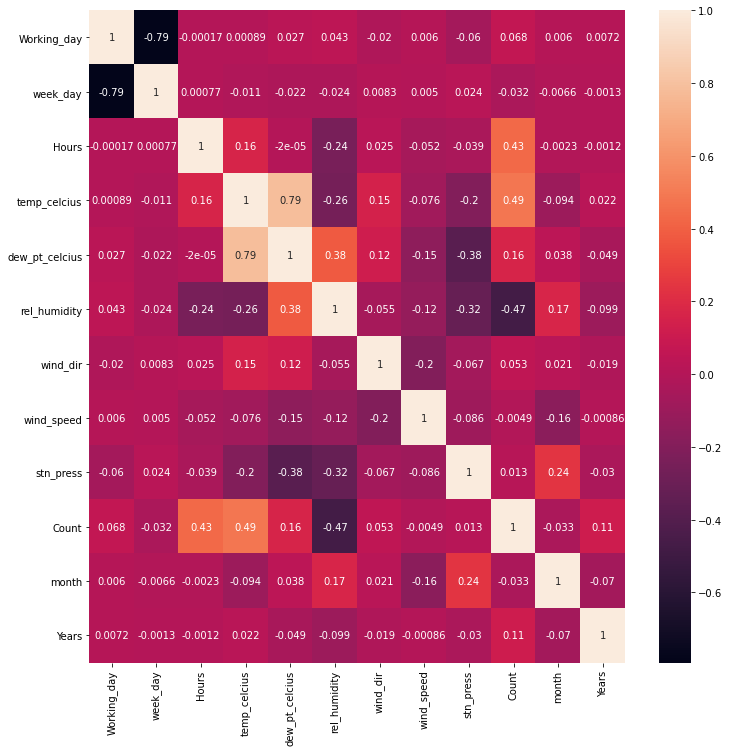

In [24]:
cor_matrix2 = BIXI_New.corr()
features_names2 = cor_matrix2.index

plt.figure(figsize=(12,12))
sns.heatmap(cor_matrix2[features_names2], annot=True)

## Feature Engineering - Relevant features

In [25]:
BIXI_New.head()

,Working_day,week_day,Hours,temp_celcius,dew_pt_celcius,rel_humidity,wind_dir,wind_speed,stn_press,Count,month,Years
start_date,,,,,,,,,,,,
2017-04-15 00:00:00,0,6,0,11.4,-5.4,30,27,8,101.76,144,4,1
2017-04-15 01:00:00,0,6,1,10.8,-6.2,30,27,9,101.70,76,4,1
2017-04-15 02:00:00,0,6,2,10.9,-6.3,29,27,11,101.65,39,4,1
2017-04-15 03:00:00,0,6,3,10.2,-6.0,31,27,9,101.61,40,4,1
2017-04-15 04:00:00,0,6,4,8.4,-4.3,40,20,4,101.58,12,4,1


In [26]:
X = BIXI_New.drop(['Count'], axis=1)
X.shape

(14954, 11)

In [27]:
Y = BIXI_New['Count']
Y.shape

(14954,)

In [28]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

model_h = ExtraTreesRegressor()
model_h.fit(X,Y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [29]:
print(model_h.feature_importances_)

[0.0627001  0.01791985 0.56193935 0.13696076 0.02270729 0.12704288
 0.00783468 0.0077816  0.01047581 0.0248364  0.01980131]


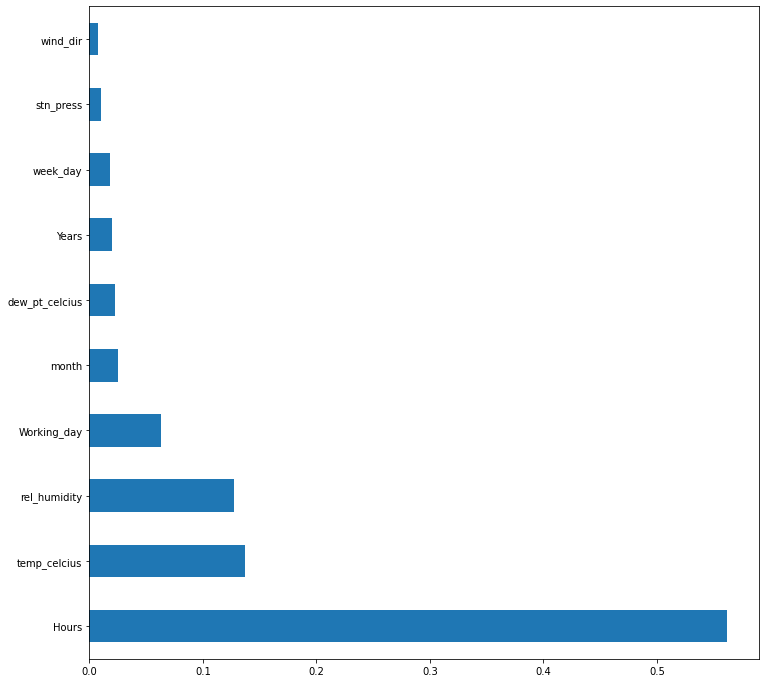

In [30]:
#Features with most importance ('Hours' column is the most important feature in relation to the 'Count')

plt.figure(figsize=(12,12))
feat_importance = pd.Series(model_h.feature_importances_, index=X.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.show()

## Feature Engineering - Data splitting

In [31]:
#Categorical features

X_cat = BIXI_New[['week_day','month']]
X_cat

,week_day,month
start_date,,
2017-04-15 00:00:00,6,4
2017-04-15 01:00:00,6,4
2017-04-15 02:00:00,6,4
2017-04-15 03:00:00,6,4
2017-04-15 04:00:00,6,4
...,...,...
2019-10-31 19:00:00,4,10
2019-10-31 20:00:00,4,10
2019-10-31 21:00:00,4,10


In [32]:
Y_Num = BIXI_New[['Hours','Working_day','Years', 'temp_celcius',	'dew_pt_celcius',	'rel_humidity',	'Count']]
Y_Num

,Hours,Working_day,Years,temp_celcius,dew_pt_celcius,rel_humidity,Count
start_date,,,,,,,
2017-04-15 00:00:00,0,0,1,11.4,-5.4,30,144
2017-04-15 01:00:00,1,0,1,10.8,-6.2,30,76
2017-04-15 02:00:00,2,0,1,10.9,-6.3,29,39
2017-04-15 03:00:00,3,0,1,10.2,-6.0,31,40
2017-04-15 04:00:00,4,0,1,8.4,-4.3,40,12
...,...,...,...,...,...,...,...
2019-10-31 19:00:00,19,1,3,12.3,11.9,97,166
2019-10-31 20:00:00,20,1,3,10.3,9.8,97,133
2019-10-31 21:00:00,21,1,3,9.2,8.7,97,119


## Feature Engineering - Data Encoding

In [33]:
# Onehotencode the categorical data
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()

X_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [34]:
Y_Num = Y_Num.reset_index()

In [35]:
Y_Num = Y_Num.drop(['start_date'], axis=1)
Y_Num

,Hours,Working_day,Years,temp_celcius,dew_pt_celcius,rel_humidity,Count
0,0,0,1,11.4,-5.4,30,144
1,1,0,1,10.8,-6.2,30,76
2,2,0,1,10.9,-6.3,29,39
3,3,0,1,10.2,-6.0,31,40
4,4,0,1,8.4,-4.3,40,12
...,...,...,...,...,...,...,...
14949,19,1,3,12.3,11.9,97,166
14950,20,1,3,10.3,9.8,97,133
14951,21,1,3,9.2,8.7,97,119
14952,22,1,3,8.5,7.9,96,121


In [36]:
X_cat = pd.DataFrame(X_cat)
BIXI_ALL = pd.concat([X_cat, Y_Num], axis=1)
# BIXI_ALL

## Feature Engineering - Neural Network Split

In [105]:
BIXI_ALL.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Hours,Working_day,Years,temp_celcius,dew_pt_celcius,rel_humidity,Count
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,11.4,-5.4,30,144
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,10.8,-6.2,30,76
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,10.9,-6.3,29,39
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0,1,10.2,-6.0,31,40
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,1,8.4,-4.3,40,12


In [106]:
X_set = BIXI_ALL.iloc[:, :-1].values
Y_set = BIXI_ALL.iloc[:, -1:].values

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_set, Y_set, test_size = 0.2, random_state=101)

In [108]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((11963, 21), (2991, 21), (11963, 1), (2991, 1))

## Feature Engineering - Normalize features

In [131]:
X_train

array([[0.        , 0.        , 1.        , ..., 0.56344086, 0.64814815,
        0.60465116],
       [0.        , 0.        , 0.        , ..., 0.73763441, 0.88194444,
        0.72093023],
       [0.        , 0.        , 0.        , ..., 0.69677419, 0.61342593,
        0.30232558],
       ...,
       [0.        , 0.        , 0.        , ..., 0.69247312, 0.7662037 ,
        0.56976744],
       [0.        , 0.        , 0.        , ..., 0.8172043 , 0.8912037 ,
        0.56976744],
       [0.        , 0.        , 0.        , ..., 0.61935484, 0.80324074,
        0.84883721]])

In [132]:
X_trainN = X_train[:, -3:]
X_testN = X_test[:, -3:]

In [133]:
X_testN

array([[0.66021505, 0.81944444, 0.76744186],
       [0.77204301, 0.72916667, 0.36046512],
       [0.40645161, 0.49074074, 0.61627907],
       ...,
       [0.6516129 , 0.78935185, 0.72093023],
       [0.55698925, 0.28472222, 0.09302326],
       [0.70967742, 0.84953704, 0.70930233]])

In [134]:
#Normalize 'X features' yet to be normalised (X_trainN, X_testN) as well as the target feature 'Y'

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_trainN = scaler.fit_transform(X_trainN)
X_testN = scaler.transform(X_testN)
Y_train = scaler.fit_transform(Y_train)
Y_test = scaler.transform(Y_test)

In [135]:
#Replace Normalised features in the train set

X_train = np.delete(X_train, np.s_[-3:], 1)
X_train = np.concatenate((X_train, X_trainN), axis=1)

X_test = np.delete(X_test, np.s_[-3:], 1)
X_test = np.concatenate((X_test, X_testN), axis=1)

In [136]:
X_train.shape, X_test.shape

((11963, 21), (2991, 21))

In [137]:
X_train

array([[0.        , 0.        , 1.        , ..., 0.56344086, 0.64814815,
        0.60465116],
       [0.        , 0.        , 0.        , ..., 0.73763441, 0.88194444,
        0.72093023],
       [0.        , 0.        , 0.        , ..., 0.69677419, 0.61342593,
        0.30232558],
       ...,
       [0.        , 0.        , 0.        , ..., 0.69247312, 0.7662037 ,
        0.56976744],
       [0.        , 0.        , 0.        , ..., 0.8172043 , 0.8912037 ,
        0.56976744],
       [0.        , 0.        , 0.        , ..., 0.61935484, 0.80324074,
        0.84883721]])

In [138]:
X_test

array([[0.        , 0.        , 0.        , ..., 0.66021505, 0.81944444,
        0.76744186],
       [0.        , 0.        , 0.        , ..., 0.77204301, 0.72916667,
        0.36046512],
       [0.        , 0.        , 1.        , ..., 0.40645161, 0.49074074,
        0.61627907],
       ...,
       [0.        , 0.        , 0.        , ..., 0.6516129 , 0.78935185,
        0.72093023],
       [0.        , 0.        , 0.        , ..., 0.55698925, 0.28472222,
        0.09302326],
       [0.        , 0.        , 0.        , ..., 0.70967742, 0.84953704,
        0.70930233]])

## Learning and Prediction - Decision Tree model

In [139]:
from sklearn.tree import DecisionTreeRegressor

In [140]:
dec_tr = DecisionTreeRegressor()

In [141]:
model_i = dec_tr.fit(X_train,Y_train)

In [142]:
dec_tr.score(X_train,Y_train)

0.9999983157851331

In [143]:
y_dtr = dec_tr.predict(X_test)
y_dtr

array([0.0597804 , 0.47763318, 0.09272062, ..., 0.05307035, 0.4847499 ,
       0.52785685])

In [144]:
Y_test

array([[0.04148028],
       [0.47051647],
       [0.29605531],
       ...,
       [0.0650671 ],
       [0.45628304],
       [0.61041074]])

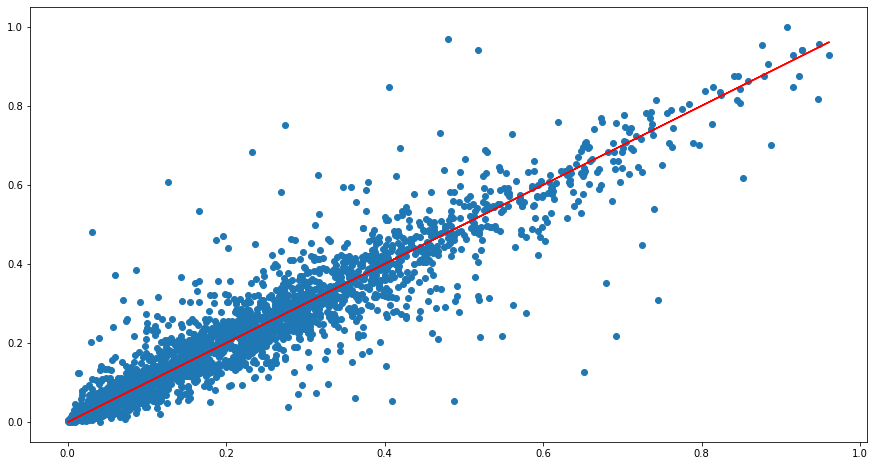

In [145]:
plt.figure(figsize=(15,8))
plt.scatter(Y_test,y_dtr)
plt.plot(Y_test,Y_test,'r')

In [146]:
# Needs more RAM to run
#plt.figure(figsize=(15,8))
#sns.displot((Y_test - y_dtr))

In [147]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
metrics.mean_squared_error(Y_test,y_dtr)

0.003888951360718171

In [148]:
metrics.mean_absolute_error(Y_test,y_dtr)

0.03571975018635048

In [149]:
np.sqrt(metrics.mean_squared_error(Y_test,y_dtr))

0.06236145733318113

In [150]:
rfr=RandomForestRegressor()
model = rfr.fit(X_train,Y_train.ravel())
rfr.score(X_train,Y_train)

0.9917333352801215

In [151]:
xfr= ExtraTreesRegressor()
model = xfr.fit(X_train,Y_train.ravel())
xfr.score(X_train,Y_train)

0.9999984458293805

In [152]:
#Y_train

## Prediction using neural network

In [153]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=50, activation='relu', input_shape=(21, )))
model.add(tf.keras.layers.Dense(units=50, activation='relu'))
model.add(tf.keras.layers.Dense(units=50, activation='relu'))
model.add(tf.keras.layers.Dense(units=40, activation='relu'))
model.add(tf.keras.layers.Dense(units=30, activation='relu'))
model.add(tf.keras.layers.Dense(units=20, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [154]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 50)                1100      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_24 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_25 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                

In [155]:
from tensorflow import keras
from tensorflow.keras import layers

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer= opt, loss='mean_squared_error', metrics='mae')

history = model.fit(X_train, Y_train, epochs = 200, validation_split=0.2, batch_size=21)

Epoch 1/200
456/456 [==============================] - 2s 3ms/step - loss: 0.0375 - mae: 0.1215 - val_loss: 0.0152 - val_mae: 0.0840
Epoch 2/200
456/456 [==============================] - 1s 3ms/step - loss: 0.0126 - mae: 0.0771 - val_loss: 0.0170 - val_mae: 0.0848
Epoch 3/200
456/456 [==============================] - 1s 3ms/step - loss: 0.0112 - mae: 0.0713 - val_loss: 0.0109 - val_mae: 0.0688
Epoch 4/200
456/456 [==============================] - 1s 3ms/step - loss: 0.0085 - mae: 0.0604 - val_loss: 0.0101 - val_mae: 0.0616
Epoch 5/200
456/456 [==============================] - 1s 3ms/step - loss: 0.0076 - mae: 0.0578 - val_loss: 0.0072 - val_mae: 0.0614
Epoch 6/200
456/456 [==============================] - 1s 3ms/step - loss: 0.0057 - mae: 0.0515 - val_loss: 0.0071 - val_mae: 0.0550
Epoch 7/200
456/456 [==============================] - 1s 3ms/step - loss: 0.0069 - mae: 0.0549 - val_loss: 0.0051 - val_mae: 0.0469
Epoch 8/200
456/456 [==============================] - 1s 3ms/step - 

Text(0, 0.5, 'Training and Validation Loss ')

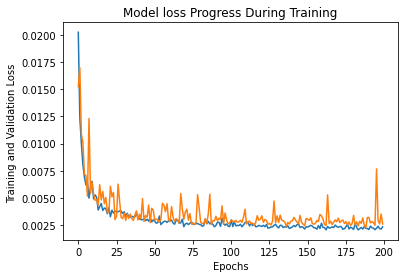

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss Progress During Training')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss ')

Text(0, 0.5, 'True Values')

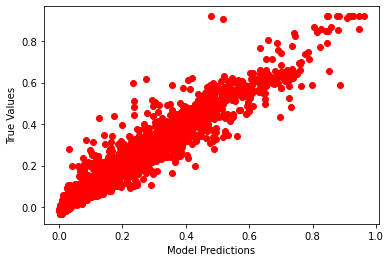

In [157]:
#Predict based on trained model
Y_predict = model.predict(X_test)
plt.plot(Y_test, Y_predict, 'o', color='r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [158]:
Y_predict_orig = scaler.inverse_transform(Y_predict)

In [159]:
Y_test_orig = scaler.inverse_transform(Y_test)

Text(0, 0.5, 'True Values')

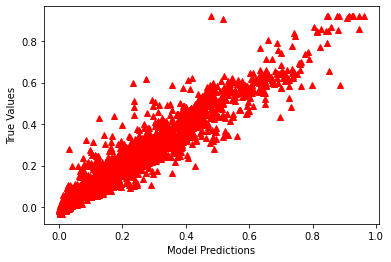

In [160]:
plt.plot(Y_test_orig, Y_predict_orig, '^', color='r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [161]:
n = len(X_test)
n

2991

In [162]:
K = X_test.shape[1]
K

21

In [163]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(Y_test_orig, Y_predict_orig)), '0.3f'))
RMSE

0.05

In [164]:
MSE = mean_squared_error(Y_test_orig, Y_predict_orig)
MAE = mean_absolute_error(Y_test_orig, Y_predict_orig)
r2= r2_score(Y_test_orig, Y_predict_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-K-1)

In [165]:
print('RMSE =', RMSE, '\nMSE =', MSE, '\nMAE =',  MAE, '\nr2 = ', r2, '\nAdjusted r2 =', adj_r2)

RMSE = 0.05 
MSE = 0.002518862097612511 
MAE = 0.03337792440831085 
r2 =  0.9237852865968381 
Adjusted r2 = 0.9232462131776847


In [166]:
model.evaluate(X_test, Y_test, verbose=1,)

94/94 [==============================] - 0s 2ms/step - loss: 0.0025 - mae: 0.0334


[0.002518861787393689, 0.03337792679667473]